# Read in Data

In [1]:
import os
import pandas as pd
import numpy as np
import xgboost

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, fbeta_score
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

import scipy.sparse as sp

from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler

from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer, LancasterStemmer

import gensim

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_data = pd.read_csv("../input/train_v2.csv")
test_data = pd.read_csv("../input/test_v2.csv")

In [3]:
train_data.head(1)

,article_id,title,url,publisher,hostname,timestamp,category
0,1,Forex - Pound drops to one-month lows against ...,http://www.nasdaq.com/article/forex-pound-drop...,NASDAQ,www.nasdaq.com,1.390000e+12,4


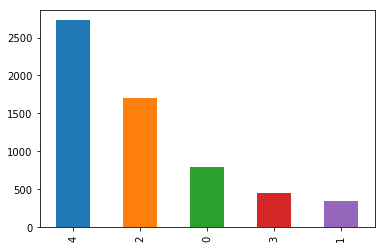

In [4]:
train_data.category.value_counts().plot('bar')

# Housekeeping

In [5]:
def stem(sent, stemmer_type='porter'):
    '''
    stemmer_type can be porter, lancaster, or snowball
    '''
    if stemmer_type == 'porter':
        stemmer = PorterStemmer()
    elif stemmer_type == 'lancaster':
        stemmer = LancasterStemmer()
    else:
        stemmer = SnowballStemmer('english')
    
    words = gensim.utils.simple_preprocess(sent)
    return ' '.join([stemmer.stem(word) for word in words])

In [6]:
def lemmatize(sent):
    lemmatizer = WordNetLemmatizer()
    
    words = gensim.utils.simple_preprocess(sent)
    return ' '.join([lemmatizer.lemmatize(word) for word in words])

In [7]:
train_data["title"][1]

'Hertz to Exit Equipment Rental Business in $2.5B Spinoff'

In [8]:
train_data["title"].apply(stem)[1]

'hertz to exit equip rental busi in spinoff'

In [9]:
# perform stemming
train_data.loc[:, "title"] = train_data["title"].apply(stem)
test_data.loc[:, "title"] = test_data["title"].apply(stem)

In [10]:
# X_train, X_test, Y_train, Y_test = train_test_split(train_data["title"], train_data["category"], test_size = 0.2)
# X_train = np.array(X_train)
# X_test = np.array(X_test)  # indeed X_valid is a more accurate name
# Y_train = np.array(Y_train)
# Y_test = np.array(Y_test)  # indeed Y_valid is a more accurate name

In [11]:
def create_sample_weight(y_true, use_log=False):
#     sr = pd.Series(y_true)
#     if use_log:
#         dc = (np.log(sr.shape[0]/sr.value_counts())).to_dict()
#     else:
#         dc = (sr.shape[0]/sr.value_counts()).to_dict()
    dc = {
        4: 1.0,
        2: 1.2,
        0: 1.0,
        3: 1.2,
        1: 1.2
    }
    return [dc[element] for element in y_true]

In [12]:
def calc_metrics(y_true, y_pred):
    return {'accuracy': accuracy_score(y_true, y_pred), 
            'f1': fbeta_score(y_true, y_pred, average=None, beta=1),
            'f2_macro': fbeta_score(y_true, y_pred, average='macro', beta=2),
            'f2_micro': fbeta_score(y_true, y_pred, average='micro', beta=2),
            'f2_weighted': fbeta_score(y_true, y_pred, average='weighted', beta=2)}

In [13]:
def train_model(classifier, feature_vector_train, label_train, feature_vector_valid, label_valid, use_sample_weight=False):
    # fit the training dataset on the classifier
    if use_sample_weight:
        classifier.fit(feature_vector_train, label_train, sample_weight=create_sample_weight(label_train, use_log=True))
    else:
        classifier.fit(feature_vector_train, label_train)
        
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    return calc_metrics(label_valid, predictions)

In [14]:
def cross_validation_data(train_data):
    sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
    
    for train_index, test_index in sss.split(train_data["title"], train_data["category"]):
        X_train, X_test = train_data["title"][train_index], train_data["title"][test_index]
        Y_train, Y_test = train_data["category"][train_index], train_data["category"][test_index]
        yield X_train, Y_train, X_test, Y_test

In [13]:
# # Not performing well
# def random_sample(X, y, method='RandomOverSampler'):
#     if method == 'RandomOverSampler':
#         sampler = RandomOverSampler()
#     elif method == 'RandomUnderSampler':
#         sampler = RandomUnderSampler()
#     elif method == 'ADASYN':
#         sampler = ADASYN()
#     elif method == 'SMOTE':
#         sampler = SMOTE()

#     return sampler.fit_sample(X, y)

In [109]:
# le_hostname = preprocessing.LabelEncoder()
# le_hostname.fit_transform(train_data['hostname']).shape

# le_publisher = preprocessing.LabelEncoder()
# publisher = le_publisher.fit_transform(train_data['publisher'].fillna('UNKNOWN'))

# TF-IDF

In [15]:
tfidf_vect_ngram = TfidfVectorizer(analyzer='word',
                                   # token_pattern=r'\w{1,}', 
                                   ngram_range=(1,2), 
                                   max_df=1.0,
                                   min_df=1,
                                   max_features=4000)
tfidf_vect_ngram.fit(train_data["title"].tolist() + test_data["title"].tolist())
# tfidf_vect_ngram.fit(train_data["title"])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=4000, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [16]:
epochs = 1

# Stage 1: binary classification for class 4

In [17]:
train_data_stage1 = train_data.copy()

In [18]:
train_data_stage1.loc[train_data_stage1['category'] != 4, 'category'] = 0

In [19]:
train_data_stage1.loc[train_data_stage1['category'] == 4, 'category'] = 1

In [25]:
train_data_stage1.head(5)

,article_id,title,url,publisher,hostname,timestamp,category
0,1,forex pound drop to one month low against euro,http://www.nasdaq.com/article/forex-pound-drop...,NASDAQ,www.nasdaq.com,1.390000e+12,1
1,2,hertz to exit equip rental busi in spinoff,http://www.foxbusiness.com/industries/2014/03/...,Fox Business,www.foxbusiness.com,1.400000e+12,0
2,3,gold etf inflow return,http://www.resourceinvestor.com/2014/03/09/gol...,Resource Investor,www.resourceinvestor.com,1.390000e+12,1
3,4,hacker call mt gox ceo liar say he still contr...,http://bgr.com/2014/03/10/mt-gox-fraud-accusat...,BGR,bgr.com,1.390000e+12,1
4,5,gold climb to near month high on concern about...,http://www.forbes.com/sites/kitconews/2014/03/...,Forbes,www.forbes.com,1.390000e+12,1


In [41]:
for clf_name in [
#                   'SVC',
#                   'LR',
                  'NB',
#                   'XGB',
#                   'RF'
                 ]:

    if clf_name == 'SVC':
        clf = SVC(kernel='linear')
    elif clf_name == 'LR':
        clf = LogisticRegression(penalty='l2', C=2, solver='liblinear', multi_class='ovr')
    elif clf_name == 'NB':
        clf = MultinomialNB()
    elif clf_name == 'XGB':
        clf = xgboost.XGBClassifier(max_depth=5, n_estimators=140)
    elif clf_name == 'RF':
        clf = RandomForestClassifier(n_estimators=180, criterion='entropy')

    metrics_list = []
    for X_train, Y_train, X_test, Y_test in cross_validation_data(train_data_stage1):
        xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(X_train)
        xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(X_test)
        xsemi_tfidf_ngram = tfidf_vect_ngram.transform(np.concatenate([X_train, X_test, test_data["title"]]))
        
        metrics = train_model(clf, xtrain_tfidf_ngram, Y_train, xvalid_tfidf_ngram, Y_test)

        metrics_list.append(metrics)

    print(clf_name, "mean accuracy:", sum([item['accuracy'] for item in metrics_list])/len(metrics_list))
    print(clf_name, "mean f2_macro:", sum([item['f2_macro'] for item in metrics_list])/len(metrics_list))    
    print(clf_name, "mean f2_micro:", sum([item['f2_micro'] for item in metrics_list])/len(metrics_list))    
    print(clf_name, "mean f2_weighted:", sum([item['f2_weighted'] for item in metrics_list])/len(metrics_list))  
    print()

NB mean accuracy: 0.7133499170812605
NB mean f2_macro: 0.7076504830319554
NB mean f2_micro: 0.7133499170812605
NB mean f2_weighted: 0.712572732719467



In [42]:
metrics['f1']

array([0.74415308, 0.63936064])

In [43]:
pd.Series(clf.predict(tfidf_vect_ngram.transform(train_data[train_data['category']==4]['title']))).value_counts()

1    1961
0     765
dtype: int64

In [44]:
pd.Series(clf.predict(tfidf_vect_ngram.transform(train_data[train_data['category']==2]['title']))).value_counts()

0    1436
1     265
dtype: int64

In [45]:
pd.Series(clf.predict(tfidf_vect_ngram.transform(train_data[train_data['category']==0]['title']))).value_counts()

0    712
1     86
dtype: int64

In [46]:
pd.Series(clf.predict(tfidf_vect_ngram.transform(train_data[train_data['category']==3]['title']))).value_counts()

0    359
1     94
dtype: int64

In [47]:
pd.Series(clf.predict(tfidf_vect_ngram.transform(train_data[train_data['category']==1]['title']))).value_counts()

0    241
1    108
dtype: int64

# Using 2 Stages

In [56]:
for clf_name in [
                  'SVC',
                  'LR',
                  'NB',
                  'XGB',
                  'RF'
                 ]:

    if clf_name == 'SVC':
        clf = SVC(kernel='linear')
        clf_2 = SVC(kernel='linear')
        
    elif clf_name == 'LR':
        clf = LogisticRegression(penalty='l2', C=2, solver='liblinear', multi_class='ovr')
        clf_2 = LogisticRegression(penalty='l2', C=2, solver='liblinear', multi_class='ovr')
    elif clf_name == 'NB':
        clf = MultinomialNB()
        clf_2 = MultinomialNB()
    elif clf_name == 'XGB':
        clf = xgboost.XGBClassifier(max_depth=5, n_estimators=140)
        clf_2 = xgboost.XGBClassifier(max_depth=5, n_estimators=140)
    elif clf_name == 'RF':
        clf = RandomForestClassifier(n_estimators=180, criterion='entropy')
        clf_2 = RandomForestClassifier(n_estimators=180, criterion='entropy')

    metrics_list = []
    for X_train, Y_train, X_test, Y_test in cross_validation_data(train_data):
        Y_train_stage_1 = Y_train.copy()
        Y_train_stage_1[Y_train_stage_1 != 4] = 0
        Y_train_stage_1[Y_train_stage_1 == 4] = 1
        
        clf.fit(tfidf_vect_ngram.transform(X_train), Y_train_stage_1)
        
        X_train_stage_2 = X_train[Y_train != 4]
        Y_train_stage_2 = Y_train[Y_train != 4]
        
        clf_2.fit(tfidf_vect_ngram.transform(X_train_stage_2), Y_train_stage_2)
        
        pred_stage_1 = clf.predict(tfidf_vect_ngram.transform(X_test))
        
        pred_stage_2 = clf_2.predict(tfidf_vect_ngram.transform(X_test[pred_stage_1 == 0]))
        
        pred_stage_1[pred_stage_1 == 1] = 4
        pred_stage_1[pred_stage_1 == 0] = pred_stage_2
        
        metrics = calc_metrics(Y_test, pred_stage_1)
        print(metrics)
        metrics_list.append(metrics)

    print(clf_name, "mean accuracy:", sum([item['accuracy'] for item in metrics_list])/len(metrics_list))
    print(clf_name, "mean f2_macro:", sum([item['f2_macro'] for item in metrics_list])/len(metrics_list))    
    print(clf_name, "mean f2_micro:", sum([item['f2_micro'] for item in metrics_list])/len(metrics_list))    
    print(clf_name, "mean f2_weighted:", sum([item['f2_weighted'] for item in metrics_list])/len(metrics_list))  
    print()

{'accuracy': 0.6177446102819237, 'f1': array([0.63430421, 0.48598131, 0.58089172, 0.51428571, 0.66666667]), 'f2_macro': 0.551638691747752, 'f2_micro': 0.6177446102819237, 'f2_weighted': 0.615238326686007}
{'accuracy': 0.6119402985074627, 'f1': array([0.66237942, 0.42477876, 0.59375   , 0.39393939, 0.65625   ]), 'f2_macro': 0.5273380312435637, 'f2_micro': 0.6119402985074627, 'f2_weighted': 0.6081498648764113}
{'accuracy': 0.6177446102819237, 'f1': array([0.6557377 , 0.48148148, 0.57032258, 0.51428571, 0.66789668]), 'f2_macro': 0.552573571485637, 'f2_micro': 0.6177446102819237, 'f2_weighted': 0.6154980443138733}
{'accuracy': 0.6252072968490879, 'f1': array([0.69400631, 0.5045045 , 0.56349206, 0.53900709, 0.67157314]), 'f2_macro': 0.5710574312342368, 'f2_micro': 0.6252072968490879, 'f2_weighted': 0.6235442335069985}
{'accuracy': 0.6393034825870647, 'f1': array([0.64094955, 0.59016393, 0.59677419, 0.61333333, 0.67799811]), 'f2_macro': 0.6084811567491245, 'f2_micro': 0.6393034825870647, 'f2

{'accuracy': 0.5953565505804311, 'f1': array([0.62706271, 0.44859813, 0.5827957 , 0.52857143, 0.62446352]), 'f2_macro': 0.5389626417064528, 'f2_micro': 0.5953565505804311, 'f2_weighted': 0.5883012479445584}
{'accuracy': 0.6011608623548922, 'f1': array([0.63157895, 0.48543689, 0.56753408, 0.453125  , 0.64646465]), 'f2_macro': 0.5244022888966794, 'f2_micro': 0.6011608623548922, 'f2_weighted': 0.5971715851788227}
XGB mean accuracy: 0.5995854063018242
XGB mean f2_macro: 0.5359533116333888
XGB mean f2_micro: 0.5995854063018242
XGB mean f2_weighted: 0.5943507983937045

{'accuracy': 0.6185737976782753, 'f1': array([0.64864865, 0.50909091, 0.59872611, 0.51315789, 0.65116279]), 'f2_macro': 0.5682841920813155, 'f2_micro': 0.6185737976782753, 'f2_weighted': 0.6163248179191275}
{'accuracy': 0.6003316749585407, 'f1': array([0.64536741, 0.44247788, 0.57834395, 0.43283582, 0.64104967]), 'f2_macro': 0.5283515727073878, 'f2_micro': 0.6003316749585407, 'f2_weighted': 0.5971042060780856}
{'accuracy': 0.6